# Import Libraries

In [1]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.9/902.9 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import statsmodels.api as sm
import numpy as np

# Import Data

In [3]:
# import train data
df_train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# import test data
df_test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Data Cleaning

In [5]:
print("Original length", len(df_train))

# remove shops not in test
df_train = df_train[df_train['shop_id'].isin(df_test['shop_id'])]
print("Removed shop length", len(df_train))

# remove items not in test
df_train = df_train[df_train['item_id'].isin(df_test['item_id'])]
print("Removed items length", len(df_train))

Original length 2935849
Removed shop length 2413246
Removed items length 1224439


# Exploratory Data Analysis

In [6]:
mon_sales = df_train.groupby(['date_block_num']) \
    .agg(item_cnt_mon=('item_cnt_day', 'sum'))
mon_sales.head()

,item_cnt_mon
date_block_num,
0,20612.0
1,22163.0
2,31599.0
3,20704.0
4,23322.0


In [7]:
sm.stats.acorr_ljungbox(mon_sales['item_cnt_mon'])

,lb_stat,lb_pvalue
1,16.856968,4.030509e-05
2,25.391796,3.063668e-06
3,33.177671,2.954385e-07
4,37.566199,1.376886e-07
5,39.879339,1.579414e-07
6,41.247013,2.588660e-07


box test p-value for all 10 lags is less than 0.05, we reject the null hypothesis and conclude that the items aggregated monthly count time series exhibit autocorrelation.

In [8]:
sns.set_theme()
def plot_ts(x, lags=10, alpha=0.05):
    plt.figure(figsize=(10, 7.5))
    ts = pd.Series(x)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    ts_ax.set_title('original time series')
    ts.plot(ax= ts_ax)
    tsa.graphics.plot_acf(ts, ax=acf_ax, lags=lags, alpha=alpha)
    tsa.graphics.plot_pacf(ts, ax=pacf_ax, lags=lags, alpha=alpha)
    plt.tight_layout()
    plt.show(block=False)

In [9]:
tsa.adfuller(mon_sales['item_cnt_mon'])[1]

0.11353011842199034

adf test p value=0.11353 is greater than 0.05, we fail to reject the null hypothesis that the time series contains a unit root thus, it is not stationary.

In [10]:
tsa.adfuller(mon_sales['item_cnt_mon'].diff()[1:])[1]

4.0326292875376784e-19

after a single difference, the adf test p-value=4.0326e-19 is less than 0.05. thus, we reject the null hypothesis and conclude that the time series is stationary.   


/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


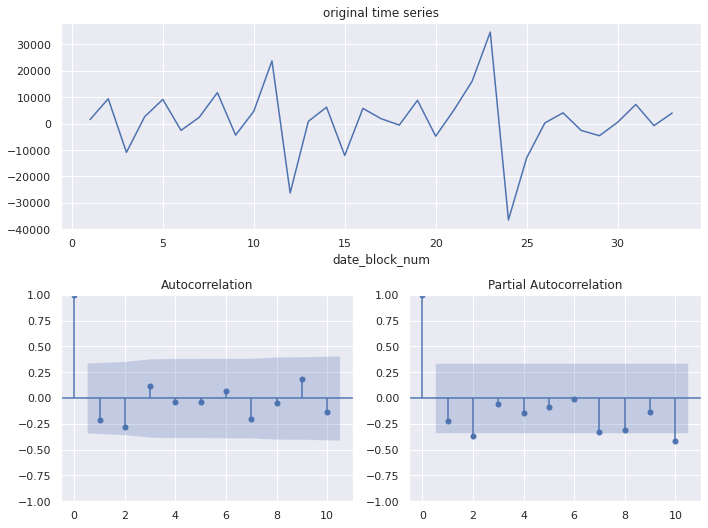

In [11]:
plot_ts(mon_sales['item_cnt_mon'].diff()[1:])

from the autocorrelation plot, the autocorelation of lags beyond 0 is not statistically different from 0.   
from the partial autocorrelation plot, the autocorrelation of lag 2 and 10 is statistically different from 0.

# Modeling

## ARIMA

In [12]:
model_2 = ARIMA(mon_sales['item_cnt_mon'], order=(2, 1, 0))
model_2_fit = model_2.fit()
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_mon   No. Observations:                   34
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -356.311
Date:                Sat, 18 Jun 2022   AIC                            718.622
Time:                        15:13:50   BIC                            723.111
Sample:                             0   HQIC                           720.133
                                 - 34                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2414      0.116     -2.082      0.037      -0.469      -0.014
ar.L2         -0.2565      0.172     -1.494      0.135      -0.593       0.080
sigma2      1.396e+08   1.77e-10   7.86e+17      0.000     1.4e+08     1.4e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 8.90
Prob(Q):                              0.71   Prob(JB):                         0.01
Heteroskedasticity (H):               2.25   Skew:                             0.63
Prob(H) (two-sided):                  0.19   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.3e+33. Standard errors may be unstable.
"""

In [13]:
model_10 = ARIMA(mon_sales['item_cnt_mon'], order=(10, 1, 0))
model_10_fit = model_10.fit()
model_10_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_mon   No. Observations:                   34
Model:                ARIMA(10, 1, 0)   Log Likelihood                -355.656
Date:                Sat, 18 Jun 2022   AIC                            733.311
Time:                        15:13:51   BIC                            749.773
Sample:                             0   HQIC                           738.850
                                 - 34                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2613      0.181     -1.443      0.149      -0.616       0.094
ar.L2         -0.2974      0.241     -1.234      0.217      -0.770       0.175
ar.L3         -0.1043      0.329     -0.317      0.751      -0.749       0.541
ar.L4         -0.0837      0.414     -0.202      0.840      -0.895       0.727
ar.L5         -0.0591      0.528     -0.112      0.911      -1.093       0.975
ar.L6         -0.0419      0.570     -0.074      0.941      -1.158       1.075
ar.L7         -0.1681      0.477     -0.353      0.724      -1.103       0.766
ar.L8         -0.0786      0.372     -0.211      0.833      -0.808       0.651
ar.L9          0.0123      0.423      0.029      0.977      -0.817       0.841
ar.L10        -0.0657      0.362     -0.182      0.856      -0.775       0.644
sigma2      1.526e+08   1.73e-09   8.83e+16      0.000    1.53e+08    1.53e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                14.53
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.92
Prob(H) (two-sided):                  0.34   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.35e+32. Standard errors may be unstable.
"""

ARIMA(2, 1, 0) has a lower AIC and BIC than ARIMA(10, 1, 0) thus, we select ARIMA(2, 1, 0) to model the time series. however, it is worth noting that the ar.l2 of the ARIMA(2, 1, 0) is not significantly different from 0 since p-value is 0.08 greater than 0.05.

In [14]:
model_21 = ARIMA(mon_sales['item_cnt_mon'], order=(2, 1, 0), enforce_stationarity=False)
with model_21.fix_params({'ar.L2': 0}):
    model_21_fit = model_21.fit()
model_21_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_mon   No. Observations:                   34
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -336.561
Date:                Sat, 18 Jun 2022   AIC                            677.122
Time:                        15:13:51   BIC                            679.990
Sample:                             0   HQIC                           678.057
                                 - 34                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1            -0.2094      0.093     -2.262      0.024      -0.391      -0.028
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
sigma2         1.396e+08   2.92e-11   4.78e+18      0.000     1.4e+08     1.4e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 4.78
Prob(Q):                              0.71   Prob(JB):                         0.09
Heteroskedasticity (H):               0.99   Skew:                             0.27
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Fixing ar.L2 of ARIMA(2, 1, 0) to 0 produces a lower AIC and BIC

### Residual Test

In [15]:
sm.stats.acorr_ljungbox(model_21_fit.resid)

,lb_stat,lb_pvalue
1,0.150745,0.697825
2,3.133056,0.208769
3,3.145299,0.369761
4,3.161725,0.531135
5,3.163176,0.674845
6,3.165634,0.787789


since box test p-value for all 6 lags of the residuals is greater than 0.05, we fail to reject the null hypothesis and conclude the residuals are white noise

In [16]:
sm.stats.acorr_ljungbox(model_21_fit.resid**2)

,lb_stat,lb_pvalue
1,9.327240,0.002258
2,9.449248,0.008874
3,10.133801,0.017462
4,11.310377,0.023289
5,13.424602,0.019709
6,15.535024,0.016480


since box test p-value for all 6 lags of the residuals square is lesser than 0.05, we reject the null hypothes is and conclude the residuals square have autocorrelation

## GARCH

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


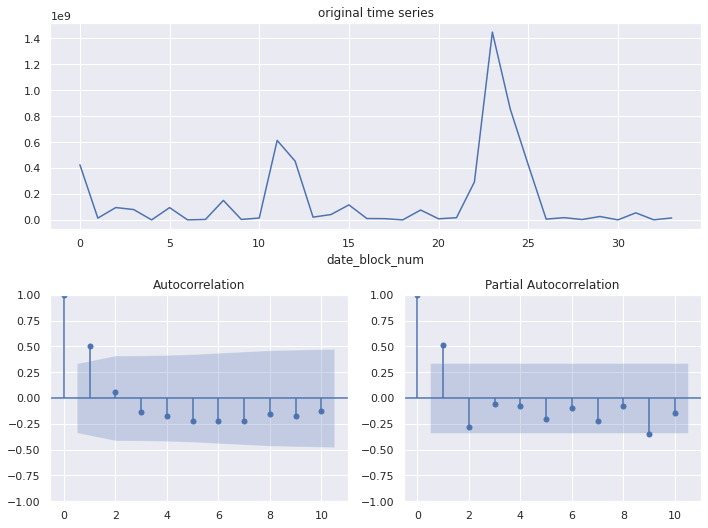

In [17]:
resid = model_21_fit.resid
plot_ts(resid**2)

from the autocorrelation plot, the autocorelation of lags beyond 1 is not statistically different from 0.  
from the partial autocorrelation plot, the autocorrelation of lag 1 and 9 is statistically different from 0.

In [18]:
garch_11  = arch_model(resid, p=1, q=1)
garch_11_fit = garch_11.fit()
garch_11_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 364.12667815737245
Iteration:      2,   Func. Count:     11,   Neg. LLF: 363.59692205898295
Iteration:      3,   Func. Count:     16,   Neg. LLF: 366.33902579408056
Iteration:      4,   Func. Count:     22,   Neg. LLF: 363.4571063086095
Iteration:      5,   Func. Count:     27,   Neg. LLF: 363.40885955366326
Iteration:      6,   Func. Count:     32,   Neg. LLF: 363.40407831491035
Iteration:      7,   Func. Count:     37,   Neg. LLF: 363.4038287311494
Iteration:      8,   Func. Count:     42,   Neg. LLF: 363.4038271338114
Iteration:      9,   Func. Count:     46,   Neg. LLF: 363.4038272304475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 363.4038271338114
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.538e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -363.404
Distribution:                  Normal   AIC:                           734.808
Method:            Maximum Likelihood   BIC:                           740.913
                                        No. Observations:                   34
Date:                Sat, Jun 18 2022   Df Residuals:                       33
Time:                        15:13:52   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu          2147.2538   1241.103      1.730  8.361e-02 [-2.853e+02,4.580e+03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.6915e+07  5.185e+07      1.483      0.138 [-2.471e+07,1.785e+08]
alpha[1]       0.5182      0.230      2.250  2.448e-02    [6.671e-02,  0.970]
beta[1]    5.7304e-13      0.468  1.225e-12      1.000      [ -0.917,  0.917]
=============================================================================

Covariance estimator: robust
"""

In [19]:
garch_91  = arch_model(resid, p=9, q=1)
garch_91_fit = garch_91.fit()
garch_91_fit.summary()

/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.538e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:     14,   Neg. LLF: 364.1266781648807
Iteration:      2,   Func. Count:     27,   Neg. LLF: 364.00561814397247
Iteration:      3,   Func. Count:     40,   Neg. LLF: 363.52373754200073
Iteration:      4,   Func. Count:     53,   Neg. LLF: 364.05136322263667
Iteration:      5,   Func. Count:     67,   Neg. LLF: 363.40815699094327
Iteration:      6,   Func. Count:     80,   Neg. LLF: 363.40391667544867
Iteration:      7,   Func. Count:     93,   Neg. LLF: 363.4038275056102
Iteration:      8,   Func. Count:    105,   Neg. LLF: 363.4038276022936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 363.4038275056102
            Iterations: 8
            Function evaluations: 105
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -363.404
Distribution:                  Normal   AIC:                           750.808
Method:            Maximum Likelihood   BIC:                           769.124
                                        No. Observations:                   34
Date:                Sat, Jun 18 2022   Df Residuals:                       33
Time:                        15:13:52   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu          2147.2541   1236.205      1.737  8.239e-02 [-2.757e+02,4.570e+03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.6915e+07  5.280e+07      1.457      0.145 [-2.656e+07,1.804e+08]
alpha[1]       0.5185      0.394      1.315      0.188      [ -0.254,  1.291]
alpha[2]   1.3648e-12      0.269  5.066e-12      1.000      [ -0.528,  0.528]
alpha[3]   6.7287e-13      0.320  2.100e-12      1.000      [ -0.628,  0.628]
alpha[4]   1.9934e-12      0.316  6.310e-12      1.000      [ -0.619,  0.619]
alpha[5]   2.6414e-12      0.273  9.675e-12      1.000      [ -0.535,  0.535]
alpha[6]   2.5506e-12      0.351  7.271e-12      1.000      [ -0.688,  0.688]
alpha[7]   2.7222e-12      0.273  9.958e-12      1.000      [ -0.536,  0.536]
alpha[8]   1.9752e-12      0.227  8.691e-12      1.000      [ -0.445,  0.445]
alpha[9]   2.9807e-12      0.133  2.239e-11      1.000      [ -0.261,  0.261]
beta[1]    1.2575e-12      0.434  2.894e-12      1.000      [ -0.852,  0.852]
=============================================================================

Covariance estimator: robust
"""

GARCH(1, 1) produces the lowest AIC score relative to the other GARCH models. however, it is worth noting the mu and beta1 is not statistically different from 0 since p-value is greater than 0.05.

In [20]:
garch_11_fix  = arch_model(resid, p=1, q=1)
garch_11_fix_fit = garch_11_fix.fit()
garch_11_fix_fit.params[['beta[1]', 'mu']] = 0
garch_11_fix_fit = garch_11_fix.fix(garch_11_fix_fit.params)
garch_11_fix_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 364.12667815737245
Iteration:      2,   Func. Count:     11,   Neg. LLF: 363.59692205898295
Iteration:      3,   Func. Count:     16,   Neg. LLF: 366.33902579408056
Iteration:      4,   Func. Count:     22,   Neg. LLF: 363.4571063086095
Iteration:      5,   Func. Count:     27,   Neg. LLF: 363.40885955366326
Iteration:      6,   Func. Count:     32,   Neg. LLF: 363.40407831491035
Iteration:      7,   Func. Count:     37,   Neg. LLF: 363.4038287311494
Iteration:      8,   Func. Count:     42,   Neg. LLF: 363.4038271338114
Iteration:      9,   Func. Count:     46,   Neg. LLF: 363.4038272304475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 363.4038271338114
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.538e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GARCH Model Results                         
=====================================================================================
Dep. Variable:                          None   R-squared:                          --
Mean Model:                    Constant Mean   Adj. R-squared:                     --
Vol Model:                             GARCH   Log-Likelihood:               -364.541
Distribution:                         Normal   AIC:                           737.081
Method:            User-specified Parameters   BIC:                           743.187
                                               No. Observations:                   34
Date:                       Sat, Jun 18 2022                                         
Time:                               15:13:52                                         
      Mean Model     
=====================
                 coef
---------------------
mu             0.0000
   Volatility Model  
=====================
                 coef
---------------------
omega      7.6915e+07
alpha[1]       0.5182
beta[1]        0.0000
=====================

Results generated with user-specified parameters.
Std. errors not available when the model is not estimated, 
"""

fixing the GARCH(1, 1) parameters of beta1 and mu result in higher AIC and BIC compared to the original

### GARCH with different distribution

In [21]:
garch_11  = arch_model(resid, p=1, q=1)
garch_11_fit = garch_11.fit()
garch_11_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 364.12667815737245
Iteration:      2,   Func. Count:     11,   Neg. LLF: 363.59692205898295
Iteration:      3,   Func. Count:     16,   Neg. LLF: 366.33902579408056
Iteration:      4,   Func. Count:     22,   Neg. LLF: 363.4571063086095
Iteration:      5,   Func. Count:     27,   Neg. LLF: 363.40885955366326
Iteration:      6,   Func. Count:     32,   Neg. LLF: 363.40407831491035
Iteration:      7,   Func. Count:     37,   Neg. LLF: 363.4038287311494
Iteration:      8,   Func. Count:     42,   Neg. LLF: 363.4038271338114
Iteration:      9,   Func. Count:     46,   Neg. LLF: 363.4038272304475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 363.4038271338114
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.538e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -363.404
Distribution:                  Normal   AIC:                           734.808
Method:            Maximum Likelihood   BIC:                           740.913
                                        No. Observations:                   34
Date:                Sat, Jun 18 2022   Df Residuals:                       33
Time:                        15:13:52   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu          2147.2538   1241.103      1.730  8.361e-02 [-2.853e+02,4.580e+03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.6915e+07  5.185e+07      1.483      0.138 [-2.471e+07,1.785e+08]
alpha[1]       0.5182      0.230      2.250  2.448e-02    [6.671e-02,  0.970]
beta[1]    5.7304e-13      0.468  1.225e-12      1.000      [ -0.917,  0.917]
=============================================================================

Covariance estimator: robust
"""

In [22]:
garch_11_std  = arch_model(resid, p=1, q=1, dist='studentst')
garch_11_fit_std = garch_11_std.fit()
garch_11_fit_std.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 363.32712718356385
Iteration:      2,   Func. Count:     13,   Neg. LLF: 362.84822926492785
Iteration:      3,   Func. Count:     19,   Neg. LLF: 363.87764507201507
Iteration:      4,   Func. Count:     26,   Neg. LLF: 362.71899162754664
Iteration:      5,   Func. Count:     32,   Neg. LLF: 362.7029751619114
Iteration:      6,   Func. Count:     38,   Neg. LLF: 362.69814250963975
Iteration:      7,   Func. Count:     44,   Neg. LLF: 362.67065031504615
Iteration:      8,   Func. Count:     50,   Neg. LLF: 362.478837683493
Iteration:      9,   Func. Count:     56,   Neg. LLF: 386.92776036826564
Iteration:     10,   Func. Count:     63,   Neg. LLF: 386.7192169723687
Iteration:     11,   Func. Count:     70,   Neg. LLF: 386.4411419751927
Iteration:     12,   Func. Count:     77,   Neg. LLF: 384.87835095469006
Iteration:     13,   Func. Count:     84,   Neg. LLF: 385.8647785875259
Iteration:     14,   Func. Count:     91,   Neg. LLF: 366

/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.538e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -362.262
Distribution:      Standardized Student's t   AIC:                           734.523
Method:                  Maximum Likelihood   BIC:                           742.155
                                              No. Observations:                   34
Date:                      Sat, Jun 18 2022   Df Residuals:                       33
Time:                              15:13:52   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu          2147.2597   1105.910      1.942  5.218e-02 [-20.284,4.315e+03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.6915e+07  6.780e+07      1.134      0.257 [-5.597e+07,2.098e+08]
alpha[1]       0.7197      0.642      1.122      0.262      [ -0.538,  1.977]
beta[1]        0.0000      0.461      0.000      1.000      [ -0.904,  0.904]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.5698      3.446      1.036      0.300 [ -3.184, 10.324]
========================================================================

Covariance estimator: robust
"""

In [23]:
garch_11_skew  = arch_model(resid, p=1, q=1, dist='skewt')
garch_11_fit_skew = garch_11_skew.fit()
garch_11_fit_skew.summary()

/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.538e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:      8,   Neg. LLF: 468.91714459247356
Iteration:      2,   Func. Count:     16,   Neg. LLF: 380.3458026206418
Iteration:      3,   Func. Count:     24,   Neg. LLF: 361.9608375135773
Iteration:      4,   Func. Count:     31,   Neg. LLF: 361.9477520702671
Iteration:      5,   Func. Count:     38,   Neg. LLF: 361.94485011607105
Iteration:      6,   Func. Count:     45,   Neg. LLF: 361.93971012070307
Iteration:      7,   Func. Count:     52,   Neg. LLF: 361.9355638067382
Iteration:      8,   Func. Count:     59,   Neg. LLF: 361.9041138002084
Iteration:      9,   Func. Count:     66,   Neg. LLF: 391.11644209760374
Iteration:     10,   Func. Count:     74,   Neg. LLF: 390.44948929111933
Iteration:     11,   Func. Count:     82,   Neg. LLF: 389.99581000328044
Iteration:     12,   Func. Count:     90,   Neg. LLF: 389.5572398310363
Iteration:     13,   Func. Count:     98,   Neg. LLF: 389.11618998357915
Iteration:     14,   Func. Count:    106,   Neg. LLF: 362

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -361.599
Distribution:      Standardized Skew Student's t   AIC:                           735.198
Method:                       Maximum Likelihood   BIC:                           744.356
                                                   No. Observations:                   34
Date:                           Sat, Jun 18 2022   Df Residuals:                       33
Time:                                   15:13:53   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu          2147.3425   1110.938      1.933  5.325e-02 [-30.056,4.325e+03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.6915e+07  9.382e+07      0.820      0.412 [-1.070e+08,2.608e+08]
alpha[1]       0.7940      0.928      0.855      0.392      [ -1.026,  2.614]
beta[1]        0.0000      0.281      0.000      1.000      [ -0.551,  0.551]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta            3.4208      3.032      1.128      0.259 [ -2.523,  9.364]
lambda         0.1915      0.172      1.111      0.267 [ -0.146,  0.529]
========================================================================

Covariance estimator: robust
"""

GARCH(1, 1) model with normal distribution produces the lowest AIC (although similar to Student's t) and BIC relative to the other distributions. 

## Forecast
### ARIMA(2, 1) ~ GARCH(1, 1) with generalized error distribution

In [24]:
arima_forecast = model_21_fit.forecast().values[0]
garch_forecast = garch_11_fit.forecast(horizon=1) \
    .mean['h.1'].iloc[-1]
forecast = arima_forecast + garch_forecast

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [25]:
submission = df_test.copy()
submission = submission.drop(['shop_id', 'item_id'], axis=1)
avg_id = forecast / len(df_test)
submission['item_cnt_month'] = avg_id
submission.to_csv('submission.csv', index=False)

In [26]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f ./submission.csv -m "Message"

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
